#  Predicting winners in League of Legends using random forests

Michael Patterson, Ph.D.

In [2]:
import requests, json
import numpy as np
from lolML.src import API_io
import importlib
import pandas as pd
import pickle
import os
from lolML.src import feature_calc
import matplotlib.pyplot as plt
import lolML.src.plotting as lol_plt
%matplotlib inline
import pdb

In [3]:
working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\lolML'
os.chdir(working_dir)
with open(working_dir+ '\\api_key.txt', 'r') as api_file:
    api_key =  api_file.read()

In [4]:
with open('EUW combined_df.pickle', 'rb') as pickle_file:
    euw_timelines_df = pickle.load(pickle_file)
with open('KR combined_df.pickle', 'rb') as pickle_file:
    kr_timelines_df = pickle.load(pickle_file)
with open('NA combined_df.pickle', 'rb') as pickle_file:
    na_timelines_df = pickle.load(pickle_file)
with open('Season 2015 Team ranked combined_df.pickle', 'rb') as pickle_file:
    team_timelines_df = pickle.load(pickle_file)

In [4]:
# load sklearn package 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

In [6]:
euw_timelines_df = [feature_calc.calc_secondary_features(x) for x in euw_timelines_df]
na_timelines_df = [feature_calc.calc_secondary_features(x) for x in na_timelines_df]
kr_timelines_df = [feature_calc.calc_secondary_features(x) for x in kr_timelines_df]
team_timelines_df = [feature_calc.calc_secondary_features(x) for x in team_timelines_df]
euw_timelines_df = feature_calc.calc_second_diff(euw_timelines_df)
na_timelines_df = feature_calc.calc_second_diff(na_timelines_df)
kr_timelines_df = feature_calc.calc_second_diff(kr_timelines_df)
team_timelines_df = feature_calc.calc_second_diff(team_timelines_df)
ten_minute_df = na_timelines_df[2]

In [7]:
col_names = na_timelines_df[0].columns
train_col = np.array([x for x in col_names if x not in
             ['winner', 'game_length', 'blue_0', 'blue_1', 'blue_2', 'blue_3', 'blue_4',
              'red_0', 'red_1', 'red_2', 'red_3', 'red_4', 'matchId', 'utctimestamp'] ])
num_features = np.size(train_col)
timeline_end = 55
time_indices = np.arange(5, timeline_end, 5)
print(train_col, )

['first_dragon' 'drag_diff' 'total_drag' 'first_baron' 'blue_barons'
 'red_barons' 'first_tower' 'tower_diff' 'total_tower' 'first_inhib'
 'blue_inhibs' 'red_inhibs' 'first_blood' 'gold_diff' 'kill_diff'
 'total_kill' 'blue_share' 'red_share' 'surrender' 'square_gold_diff'
 'gold_diff_diff' 'tower_diff_diff' 'kill_diff_diff' 'drag_diff_diff']


In [8]:
import matplotlib as mpl
mpl.rc('font', size=22)
mpl.rc('lines', linewidth=3)
mpl.rc('figure',figsize=[8, 6])
mpl.rc('xtick', labelsize='large')
mpl.rcParams.update({'xtick.labelsize':34}) 
mpl.rcParams.update({'xtick.major.size':6})

# What is League of Legends?

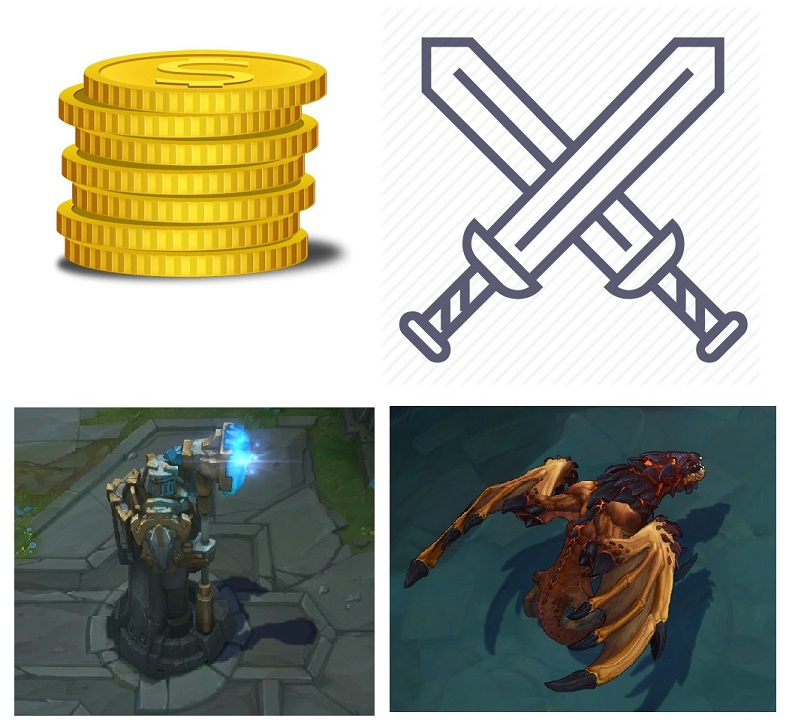

In [23]:
from IPython.display import Image
Image(filename='LoL features.jpg', width=600) 

# Predict the winner before the game is over

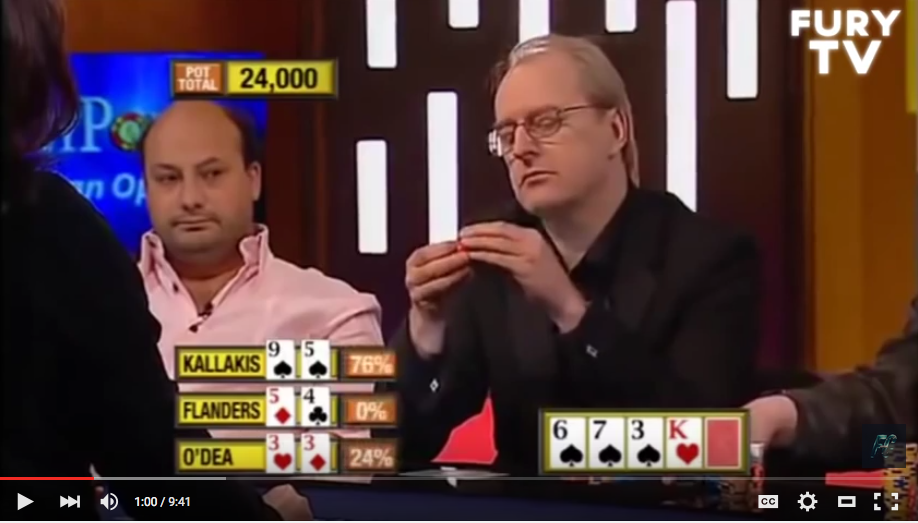

In [7]:
Image(filename='Poker prediction.png') 

# Use Riot Game's API to download JSON Data

In [28]:
import requests, json
match_info = requests.get(match_urls[cur_match],
                          match_info_params)
match_info.json()

{'mapId': 11,
 'matchCreation': 1442681043081,
 'matchDuration': 2160,
 'matchId': 1955239698,
 'matchMode': 'CLASSIC',
 'matchType': 'MATCHED_GAME',
 'matchVersion': '5.18.0.297',
 'participantIdentities': [{'participantId': 1,
   'player': {'matchHistoryUri': '/v1/stats/player_history/NA/36154943',
    'profileIcon': 575,
    'summonerId': 22403576,
    'summonerName': 'Pants are Dragon'}},
  {'participantId': 2,
   'player': {'matchHistoryUri': '/v1/stats/player_history/NA1/46840062',
    'profileIcon': 7,
    'summonerId': 31937841,
    'summonerName': 'IRL 54bomb99'}},
  {'participantId': 3,
   'player': {'matchHistoryUri': '/v1/stats/player_history/NA/33661240',
    'profileIcon': 752,
    'summonerId': 20616684,
    'summonerName': 'Drunken Immortal'}},
  {'participantId': 4,
   'player': {'matchHistoryUri': '/v1/stats/player_history/NA1/45192236',
    'profileIcon': 523,
    'summonerId': 30871780,
    'summonerName': 'CloudNguyen'}},
  {'participantId': 5,
   'player': {'match

Quickly through this. Everyone knows requests

## Explore data and create features

Plot the length of games

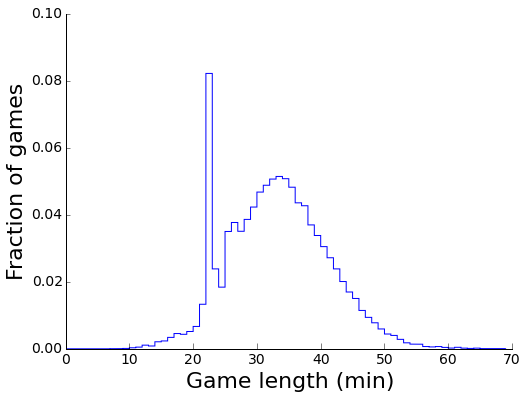

In [16]:
import matplotlib as plt
plt.hist(np.array(na_timelines_df[0]['game_length']), bins = range(0, 70),
         histtype='step', normed=True);
plt.xlabel('Game length (min)')
plt.ylabel('Fraction of games')
plt.ylim([0, 0.1])
lol_plt.prettify_axes(plt.gca())

Don't mention data frames yet!

Some games don't even last twenty minutes! There is also a large spike of games ending around 20 minutes due to surrenders. When we create features, the feature calculator will have to consider game length.

## Create a dataframe every 5 minutes

In [17]:
for i in range(len(na_timelines_df)):
    print('Number of games at {0} min: {1}'.format( (i+1)*5,
                                                   na_timelines_df[i].shape[0]))

Number of games at 5 min: 35783
Number of games at 10 min: 35765
Number of games at 15 min: 35519
Number of games at 20 min: 34655
Number of games at 25 min: 28469
Number of games at 30 min: 21290
Number of games at 35 min: 12341
Number of games at 40 min: 5625
Number of games at 45 min: 1934
Number of games at 50 min: 540


## Create features for gold, kills, towers, and dragons

In [47]:
import pandas as pd
na_timelines_df[4][['gold_diff', 'kill_diff', 'tower_diff',
                    'drag_diff', 'winner', 'game_length']].head(3)

,gold_diff,kill_diff,tower_diff,drag_diff,winner,game_length
matchId,,,,,,
1942726245,-232,-1,-1,2,1,35
1942729228,10535,7,8,2,1,35
1942738358,2406,2,1,-2,0,38


### Is there correlation between features?

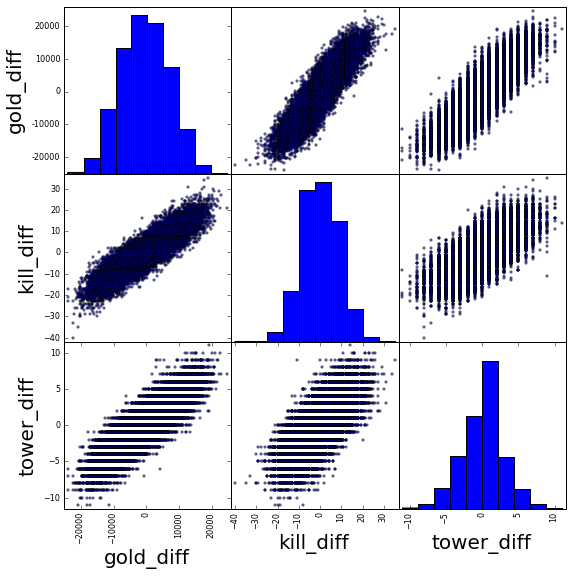

In [57]:
pd.tools.plotting.scatter_matrix(na_timelines_df[4][['gold_diff', 'kill_diff', 'tower_diff']], figsize = [9, 9]);

# Predict winners using random forests

### Why random forests?

It allows me to look at feature importance

It is resilient to multi-collinearity.

I had never used it before!

In [17]:
important_col = ['blue_inhibs', 'blue_barons', 'drag_diff', 'first_baron', 'first_inhib',
                 'gold_diff', 'gold_diff_diff', 'kill_diff', 'kill_diff_diff', 'red_barons',
                 'red_inhibs', 'tower_diff']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 25, max_features = 'sqrt',
                             min_samples_leaf=10, min_samples_split=25)

In [19]:
def cross_validate_df(cur_df):
    return cross_validation.cross_val_score(rfc, cur_df[important_col], cur_df['winner'],
                                            cv=4, n_jobs = -1)

In [46]:
accuracy_timeline = [cross_validate_df(x) for x in na_timelines_df]

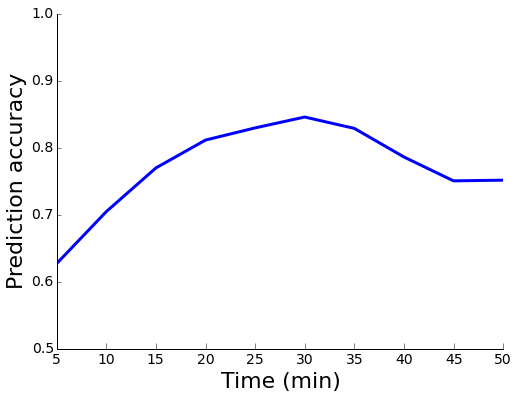

In [63]:
plt.plot(time_indices, np.mean(accuracy_timeline, 1))
plt.ylim( 0.5, 1)
plt.xlabel('Time (min)')
plt.ylabel('Prediction accuracy')
lol_plt.prettify_axes(plt.gca())

The game does get more easily predicted with time, as more information is gathered by the model. However, once you reach 30 minutes, the model loses accuracy. This is probably because as the game enters the late phase, gold matters less, and objectives more, and a single decisive teamfight can decide the game either way.

# Which features are important?

In [22]:
feature_importances  = np.zeros([len(na_timelines_df), np.size(train_col)])
for i, cur_df in enumerate(na_timelines_df):
    rfc.fit(cur_df[train_col], cur_df['winner'])
    
    feature_importances[i] = rfc.feature_importances_

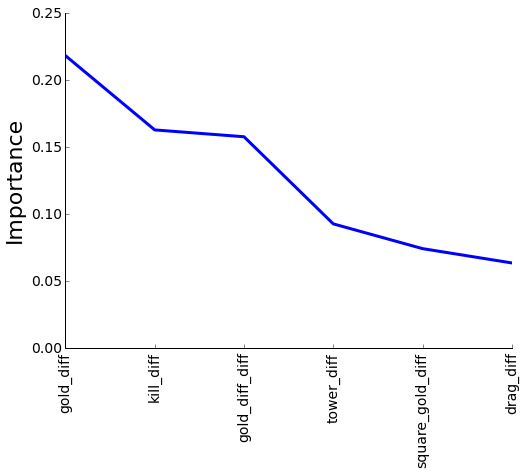

In [45]:
indices_at_20 = np.argsort(feature_importances[3])[::-1]
plt.plot(feature_importances[3,indices_at_20[:6]])
plt.ylabel('Importance')
x_tick_labels = [str(x) for x in train_col[indices_at_20]]
plt.gca().set_xticklabels(x_tick_labels, rotation = 90)
plt.ylim([0, 0.25])
lol_plt.prettify_axes(plt.gca())

# More information

github.com/map222/lolML

trailofpapers.net

Python requests is great

Machine learning with scikit learn is easy

Dragons don't matter

# Extra slides!

### How are these features distributed?

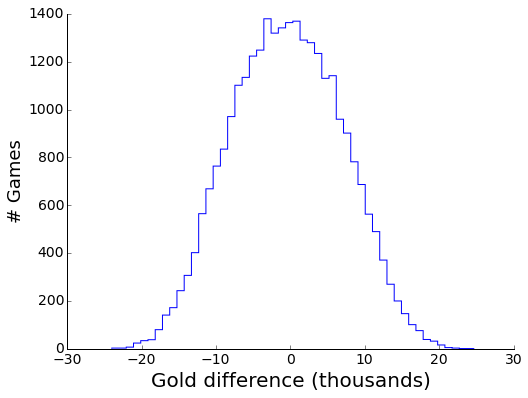

In [55]:
plt.hist(na_timelines_df[4]['gold_diff'].values / 1000, bins = 50, histtype='step')
plt.ylabel('# Games', fontsize = 18)
plt.xlabel('Gold difference (thousands)')
lol_plt.prettify_axes(plt.gca())

# How does skill level impact predictability?

In [74]:
solo_lengths = np.array( na_timelines_df[0]['game_length'])
team_lengths =np.array( team_timelines_df[0]['game_length'])

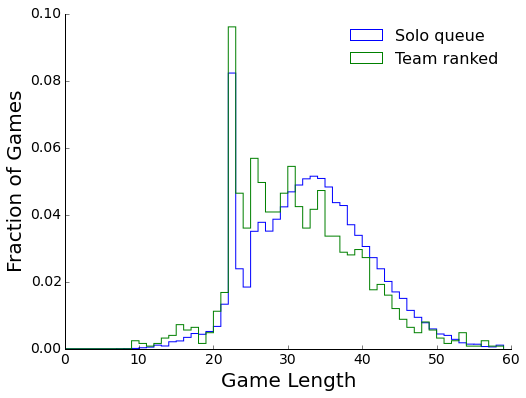

In [80]:
plt.hist(solo_lengths, bins = range(0, 60), histtype='step',
         normed=True, label = 'Solo queue')
plt.hist(team_lengths, bins = range(0, 60), histtype='step',
         normed=True,label = 'Team ranked')
lol_plt.prettify_axes(plt.gca())
plt.xlabel('Game Length')
plt.ylabel('Fraction of Games')
plt.legend(frameon=False, fontsize = 16);

## Are team games easier to predict than solo queue games?

In [81]:
team_scores = [cross_validate_df(x) for x in team_timelines_df]

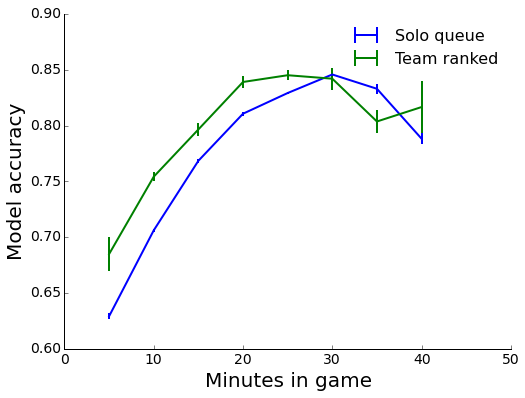

In [88]:
plt.errorbar(time_indices[:-2], np.mean(accuracy_timeline[:-2], 1),
             np.std(accuracy_timeline[:-2], 1) / np.sqrt(4), label = 'Solo queue', capsize = 0)
plt.errorbar(time_indices[:-2], np.mean(team_scores[:-2], 1),
             np.std(team_scores[:-2], 1) / np.sqrt(4), label = 'Team ranked', capsize = 0)
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Model accuracy')
plt.xlabel('Minutes in game')
plt.xlim([0, 50])
plt.legend(frameon=False, fontsize=16);

# Exploring model hyper-parameters
### How does model accuracy depend on splitting criterion? 

In [70]:
def score_by_min_split(cur_min_split, cur_df):
    split_forest = RandomForestClassifier(n_jobs = -1, n_estimators = 25,
                                          max_features = 'sqrt', min_samples_split = cur_min_split)
    return cross_validation.cross_val_score(split_forest, cur_df[important_col],
                                            cur_df['winner'], cv=10, n_jobs = -1)

min_samples_array = list(range(1, 25, 5))
min_split_scores = list(map(lambda x: score_by_min_split(x, ten_minute_df),
                            min_samples_array))

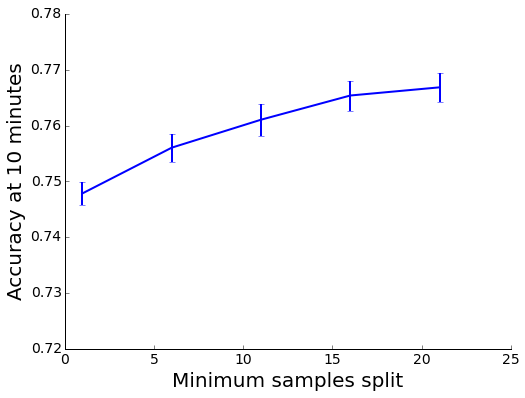

In [73]:
plt.errorbar(min_samples_array, np.mean(min_split_scores, 1),
             np.std(min_split_scores, 1) / np.sqrt(5))
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 10 minutes')
plt.xlabel('Minimum samples split')
plt.ylim([0.72, 0.78]);

## Are surrendered games winnable?

In [99]:
surrender_at_20_df = timelines_df[3].query('(surrender == 1) & (game_length <=25)')
good_games_df = timelines_df[3].query('(surrender == 0) | (game_length >25)')
surrender_at_20_df[['surrender', 'game_length']].head(2)

,surrender,game_length
matchId,,
1947508622,1,22
1947379227,1,25


In [102]:
close_forest = RandomForestClassifier(n_jobs = 3, n_estimators = 20, max_features = 'sqrt')
close_forest.fit(good_games_df[important_col], good_games_df['winner'])
cross_score = np.mean(np.max(close_forest.predict_proba(surrender_at_20_df[important_col]), axis = 1))
print('A forest trained on non-surrender games predicts the team that won would do so with {:.2f} probability'.format(cross_score))

A forest trained on non-surrender games predicts the team that won would do so with 0.93 probability


## Forest size versus prediction accuracy

In [15]:
forest_sizes = np.arange(5, 205, 25)
def score_by_size(cur_size):
    size_forest = RandomForestClassifier(n_jobs = 4, n_estimators = cur_size, max_features = 'sqrt')
    return cross_validation.cross_val_score(size_forest, euw_timelines_df[3][important_col],  euw_timelines_df[3]['winner'], cv=5, n_jobs = 4)

size_scores = list(map(score_by_size, forest_sizes))

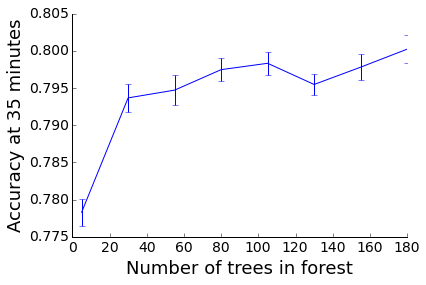

In [17]:
plt.errorbar(forest_sizes, np.mean(size_scores, 1), np.std(size_scores, 1) / np.sqrt(5))
lol_plt.prettify_axes(plt.gca())
plt.ylabel('Accuracy at 35 minutes', fontsize = 18)
plt.xlabel('Number of trees in forest', fontsize = 18)
#plt.ylim([0.8, 0.85]);